In [6]:
# @title Colab Setup and Imports { display-mode: "form" }
# @markdown (double click to see the code)

import os
import random

import git
import numpy as np
from gym import spaces

%matplotlib inline
from matplotlib import pyplot as plt

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
os.chdir(dir_path)

from PIL import Image

import habitat
from habitat.core.logging import logger
from habitat.core.registry import registry
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat.tasks.nav.nav import NavigationTask
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.config.default import get_config as get_baselines_config
import habitat_sim

In [7]:
os.getcwd()

'/data/reventh/habitat-lab'

In [8]:
dir_path

'/data/reventh/habitat-lab'

In [9]:
def display_sample(
    obs
):  # noqa: B006
    rgb_img = Image.fromarray(obs[0]['rgb'], mode="RGB")
    return rgb_img

In [11]:
config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            # "habitat-baselines/habitat_baselines/config/objectnav/hssd-200_ver_clip_hssd-hab.yaml"
            "habitat-lab/habitat/config/benchmark/nav/objectnav/objectnav_hssd-hab.yaml",
        ))

In [14]:
import json
from omegaconf import OmegaConf
print(json.dumps(OmegaConf.to_container(config), indent=4))

{
    "habitat": {
        "seed": 100,
        "env_task": "GymHabitatEnv",
        "env_task_gym_dependencies": [],
        "env_task_gym_id": "",
        "environment": {
            "max_episode_steps": 500,
            "max_episode_seconds": 10000000,
            "iterator_options": {
                "cycle": true,
                "shuffle": true,
                "group_by_scene": true,
                "num_episode_sample": -1,
                "max_scene_repeat_episodes": -1,
                "max_scene_repeat_steps": 10000,
                "step_repetition_range": 0.2
            }
        },
        "simulator": {
            "type": "Sim-v0",
            "forward_step_size": 0.25,
            "turn_angle": 30,
            "create_renderer": false,
            "requires_textures": true,
            "auto_sleep": false,
            "step_physics": true,
            "concur_render": false,
            "needs_markers": true,
            "update_articulated_agent": true,
            

In [15]:
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.config.default_structured_configs import (
    CollisionsMeasurementConfig,
    FogOfWarConfig,
    TopDownMapMeasurementConfig,
)
config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat-baselines/habitat_baselines/config/objectnav/hssd-200_ver_clip_hssd-hab.yaml"
            # "habitat-lab/habitat/config/benchmark/nav/objectnav/objectnav_hssd-hab.yaml",
        ),
        overrides=[
            # "habitat.environment.iterator_options.shuffle=False",
            "habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.height=512",
            "habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.width=512",
            # "habitat.simulator.create_renderer=False",
            "habitat.simulator.habitat_sim_v0.enable_hbao=True",
            "habitat_baselines.eval.video_option=[\"disk\"]",
            "habitat_baselines.rl.ddppo.pretrained_weights=data/ddppo-models/hssd_pretrained_best_on_hm3d_ckpt.pth",
            "habitat.simulator.habitat_sim_v0.allow_sliding=false"])

# with habitat.config.read_write(config):
#         config.habitat.task.measurements.update(
#             {
#                 "top_down_map": TopDownMapMeasurementConfig(
#                     map_padding=3,
#                     map_resolution=512,
#                     draw_source=True,
#                     draw_border=True,
#                     draw_shortest_path=True,
#                     draw_view_points=True,
#                     draw_goal_positions=True,
#                     draw_goal_aabbs=True,
#                     fog_of_war=FogOfWarConfig(
#                         draw=True,
#                         visibility_dist=5.0,
#                         fov=90,
#                     ),
#                 ),
#                 "collisions": CollisionsMeasurementConfig(),
#             }
#         )

In [16]:
from dataclasses import dataclass
import math

import habitat
from habitat.config.default_structured_configs import ActionConfig
from habitat.tasks.nav.nav import SimulatorTaskAction
from loguru import logger

# This is the configuration for our action.
@dataclass
class ParamaterizedActionConfig(ActionConfig):
    pos_cord = [0.0, 0.0, 0.0]
    angle_cord = [0.0, 0.0, 0.0, 0.0]

@habitat.registry.register_task_action
class ParamaterizedChangeLocation(SimulatorTaskAction):
    def __init__(self, *args, config, sim, **kwargs):
        super().__init__(*args, config=config, sim=sim, **kwargs)
        self.pos_cord = np.array([0.0, 0.0, 0.0])
        self.angle_cord = np.array([0.0, 0.0, 0.0, 0.0])

    # Change state of simulator by specified translation amountS
    def param_change_loc(self):
        self._sim.set_agent_state(
            self.pos_cord,
            self.angle_cord,
            reset_sensors=False,
        )
        
        
    def _get_uuid(self, *args, **kwargs) -> str:
        return "param_change_loc"

    # Step method for translation
    def step(self, pos_crd, angle_crd, **kwargs):
        self.pos_cord = pos_crd
        self.angle_cord = angle_crd
        self.param_change_loc()
    
with habitat.config.read_write(config):
    config.habitat.task.actions["param_chl"] = ParamaterizedActionConfig(type="ParamaterizedChangeLocation")
env = habitat.Env(config=config)

2024-05-14 05:27:52,386 Initializing dataset ObjectNav-v1


2024-05-14 05:28:06,977 initializing sim Sim-v0
2024-05-14 05:28:11,943 Initializing task ObjectNav-v1


In [17]:
class SimpleRLEnv(habitat.RLEnv):
    def get_reward_range(self):
        return [-1, 1]

    def get_reward(self, observations):
        return 0

    def get_done(self, observations):
        return self.habitat_env.episode_over

    def get_info(self, observations):
        return self.habitat_env.get_metrics()
    


In [18]:
env = SimpleRLEnv(config=config)

2024-05-14 05:28:12,026 Initializing dataset ObjectNav-v1
2024-05-14 05:28:27,722 initializing sim Sim-v0
2024-05-14 05:28:30,258 Initializing task ObjectNav-v1


In [19]:
goal_radius = env.episodes[0].goals[0].radius
if goal_radius is None:
    goal_radius = config.habitat.simulator.forward_step_size
follower = ShortestPathFollower(
    env.habitat_env.sim, goal_radius, False
)
print(goal_radius)
follower = ShortestPathFollower(env.habitat_env.sim, goal_radius, False)

0.25


In [20]:




def draw_top_down_map(info, output_size):
    return maps.colorize_draw_agent_and_fit_to_height(
        info["top_down_map"], output_size
    )

In [21]:
env.reset()
default_spawn = env.habitat_env.sim.get_agent_state().position, env.habitat_env.sim.get_agent_state().rotation

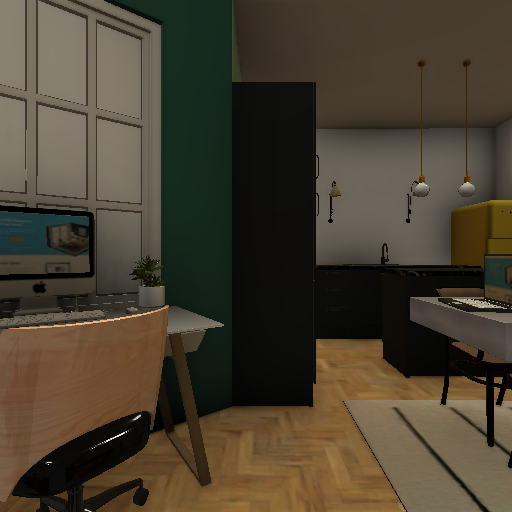

In [22]:
obs = env.step({'action': 'param_chl', 'action_args':{'pos_crd':default_spawn[0], 'angle_crd':default_spawn[1]}})
display_sample(obs)

In [24]:
from habitat.utils.visualizations.utils import images_to_video


In [25]:
# Use this for object navigation task
import shutil

path = None

for episode in range(3):
    env.reset()
    env.step({"action": "param_chl", "action_args": {"pos_crd": default_spawn[0], "angle_crd": default_spawn[1]}})
    IMAGE_DIR = f'{os.getcwd()}/examples/tutorials'
    dirname = os.path.join(
        IMAGE_DIR, "shortest_path_example", "%02d" % episode
    )
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.makedirs(dirname)
    print("Agent stepping around inside environment.")
    images = []
    path = []
    while not env.habitat_env.episode_over:
        best_action = follower.get_next_action(
            env.habitat_env.current_episode.goals[0].view_points[0].agent_state.position

        )
        if best_action is None:
            break
        observations, reward, done, info = env.step(best_action)
        im = observations["rgb"]
        path.append((env.habitat_env.sim.get_agent_state().position, env.habitat_env.sim.get_agent_state().rotation))
        print(info)
        # top_down_map = draw_top_down_map(info, im.shape[0])
        # output_im = np.concatenate((im, top_down_map), axis=1)
        output_im = im
        images.append(output_im)
    images_to_video(images, dirname, "trajectory")
    print("Episode finished")

Agent stepping around inside environment.
{'distance_to_goal': 5.300988674163818, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.37349303007566004, 'distance_to_goal_reward': 0.0007491111755371094}
{'distance_to_goal': 5.300988674163818, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.37349303007566004, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 5.300988674163818, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.37349303007566004, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 5.300988674163818, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.37349303007566004, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 5.300988674163818, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.37349303007566004, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 5.055066108703613, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.4025578349248793, 'distance_to_goal_reward': 0.24592256546020508}
{'distance_to_goal': 4.810185432434082, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.43149950220864275, 'distance_to_goal_rewa

2024-05-14 05:29:15,522 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/00/trajectory.mp4


{'distance_to_goal': 0.07194962352514267, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.880764418733493, 'distance_to_goal_reward': 0.0016838610172271729}
{'distance_to_goal': 0.07194962352514267, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.880764418733493, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.0678071603178978, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8586621484415602, 'distance_to_goal_reward': 0.004142463207244873}
{'distance_to_goal': 0.06147234886884689, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8378809303701429, 'distance_to_goal_reward': 0.006334811449050903}
{'distance_to_goal': 0.061470549553632736, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8174946134864997, 'distance_to_goal_reward': 1.7993152141571045e-06}
{'distance_to_goal': 0.06780176609754562, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.7974750570819542, 'distance_to_goal_reward': -0.006331216543912888}
{'distance_to_goal': 0.07399526238441467, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.7783972680579875, 'dista

100%|███████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 58.67it/s]


Episode finished
Agent stepping around inside environment.
{'distance_to_goal': 5.300988674163818, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.05840420513055067, 'distance_to_goal_reward': 0.0007491111755371094}
{'distance_to_goal': 5.300988674163818, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.05840420513055067, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 5.300988674163818, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.05840420513055067, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 5.300988674163818, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.05840420513055067, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 5.300988674163818, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.05840420513055067, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 5.055066108703613, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.10208655718487991, 'distance_to_goal_reward': 0.24592256546020508}
{'distance_to_goal': 4.810185432434082, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.14558384216192222, 'dis

2024-05-14 05:29:16,790 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/01/trajectory.mp4


{'distance_to_goal': 0.06393726170063019, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8978041851865509, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.07363348454236984, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8614989420083461, 'distance_to_goal_reward': -0.009696222841739655}
{'distance_to_goal': 0.07363348454236984, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8614989420083461, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.07194962352514267, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8296020143505163, 'distance_to_goal_reward': 0.0016838610172271729}
{'distance_to_goal': 0.07194962352514267, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8296020143505163, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.0678071603178978, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8003537903478642, 'distance_to_goal_reward': 0.004142463207244873}
{'distance_to_goal': 0.06147234886884689, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.7734413760112361, 'distance_to_goal_reward': 0.0063348114

100%|██████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 132.25it/s]
2024-05-14 05:29:17,524 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/02/trajectory.mp4


Episode finished
Agent stepping around inside environment.
{'distance_to_goal': 1.9506940841674805, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.2865506163131293, 'distance_to_goal_reward': 0.0017209053039550781}
{'distance_to_goal': 1.9506940841674805, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.2865506163131293, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.9506940841674805, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.2865506163131293, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.9506940841674805, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.2865506163131293, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.9506940841674805, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.2865506163131293, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.7182625532150269, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.3715604258231613, 'distance_to_goal_reward': 0.2324315309524536}
{'distance_to_goal': 1.494006872177124, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.4535799893843304, 'dista

100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 110.50it/s]


Episode finished


In [29]:
env.reset()
env.step({"action": "param_chl", "action_args": {"pos_crd": default_spawn[0], "angle_crd": default_spawn[1]}})


({'rgb': array([[[137, 129, 112],
          [137, 129, 112],
          [137, 129, 112],
          ...,
          [ 72,  60,  47],
          [ 72,  60,  47],
          [ 72,  60,  47]],
  
         [[137, 129, 112],
          [137, 129, 112],
          [137, 129, 112],
          ...,
          [ 72,  60,  47],
          [ 72,  60,  47],
          [ 72,  60,  47]],
  
         [[137, 129, 112],
          [137, 129, 112],
          [137, 129, 112],
          ...,
          [ 72,  60,  47],
          [ 72,  61,  47],
          [ 72,  61,  47]],
  
         ...,
  
         [[ 85,  60,  30],
          [ 82,  58,  27],
          [ 85,  59,  29],
          ...,
          [121, 113,  86],
          [121, 113,  86],
          [123, 114,  87]],
  
         [[ 82,  58,  27],
          [ 84,  60,  30],
          [ 89,  63,  34],
          ...,
          [122, 114,  87],
          [122, 114,  87],
          [123, 114,  87]],
  
         [[ 85,  59,  30],
          [ 90,  62,  34],
          [ 88,  

In [34]:
env.reset()
env.step({"action": "param_chl", "action_args": {"pos_crd": default_spawn[0], "angle_crd": default_spawn[1]}})
env.habitat_env.current_episode

ObjectGoalNavEpisode(episode_id='135', scene_id='data/scene_datasets/hssd-hab/scenes/104348394_171513453', scene_dataset_config='data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json', additional_obj_config_paths=[], start_position=[-13.81553, 0.13964, -2.08272], start_rotation=[0, 0.90052, 0, -0.43481], info={'geodesic_distance': 2.82019, 'euclidean_distance': 2.42917, 'closest_goal_object_id': 8}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7f29d6c434f0>, goals=[ObjectGoal(position=[-16.96485, 0.42782, -4.07402], radius=None, object_id=8, object_name='0070649630e7b2262ec0427c0e2035232240fb4d_:0000', object_name_id=None, object_category='chair', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-16.42584, 0.13964, -3.89361], rotation=[0.0, 0.58421, 0.0, 0.8116]), iou=0.27445), ObjectViewLocation(agent_state=AgentState(position=[-16.42584, 0.13964, -3.98361], rotation=[0.0, 0.64598,

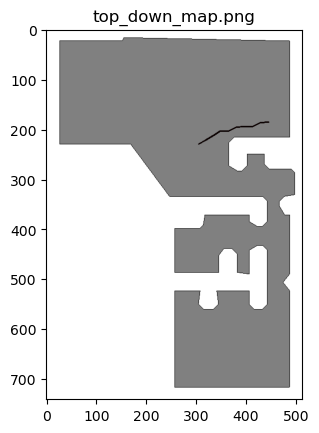

In [26]:
from habitat.utils.visualizations import maps

top_down_map = maps.get_topdown_map_from_sim(env.habitat_env.sim, map_resolution=512)
recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        # By default, `get_topdown_map_from_sim` returns image
        # containing 0 if occupied, 1 if unoccupied, and 2 if border
        # The line below recolors returned image so that
        # occupied regions are colored in [255, 255, 255],
        # unoccupied in [128, 128, 128] and border is [0, 0, 0]
top_down_map = recolor_map[top_down_map]
reformatted_path = [maps.to_grid(x[0][2], x[0][0], (top_down_map.shape[0], top_down_map.shape[1]), env.habitat_env.sim) for x in path]
maps.draw_path(top_down_map, reformatted_path, color=10, thickness=2)
plt.imshow(top_down_map)
plt.title("top_down_map.png")
plt.show()


34


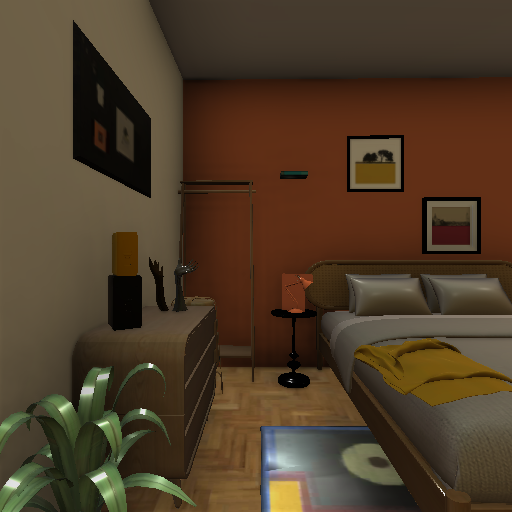

In [17]:
import random
env.reset()
# rand = random.randint(0, len(path))
rand = 34
print(rand)
obs = env.step({"action":("param_chl"), "action_args":{"pos_crd": path[rand][0], "angle_crd": path[rand][1]}})
display_sample(obs)

In [18]:
_sim = env.habitat_env.sim
obj_template_mgr = _sim.get_object_template_manager()
rigid_obj_mgr = _sim.get_rigid_object_manager()
obj_template = obj_template_mgr.get_template_by_id(2) # Adds cone
# obj_template.scale *= 
id = obj_template_mgr.register_template(obj_template)
print(id)
obj = rigid_obj_mgr.add_object_by_template_id(id)
obj.translation = path[rand][0]


In [19]:
obj_template.handle

'coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true'

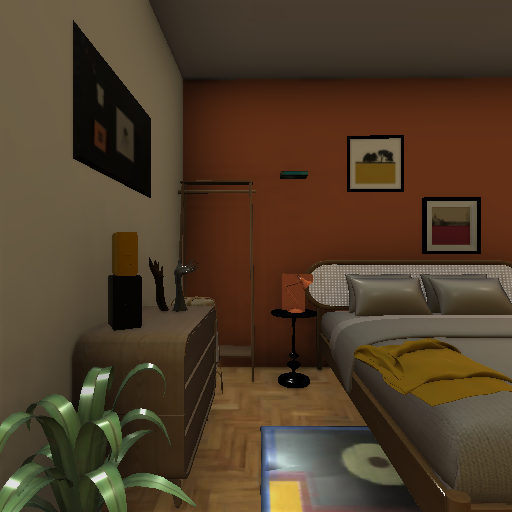

In [20]:
Image.fromarray(_sim.get_sensor_observations()['rgb'])

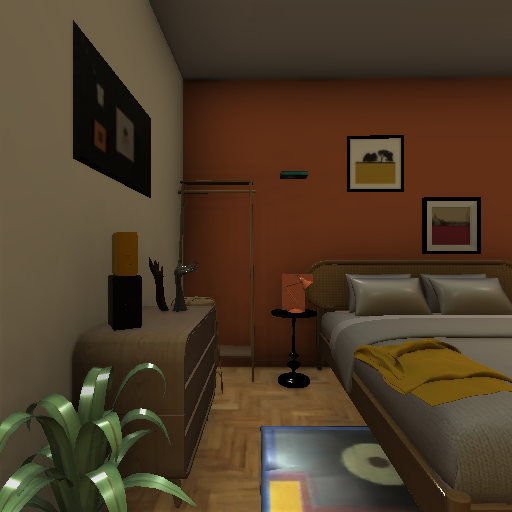

In [36]:
obs = env.step('turn_left')
display_sample(obs)

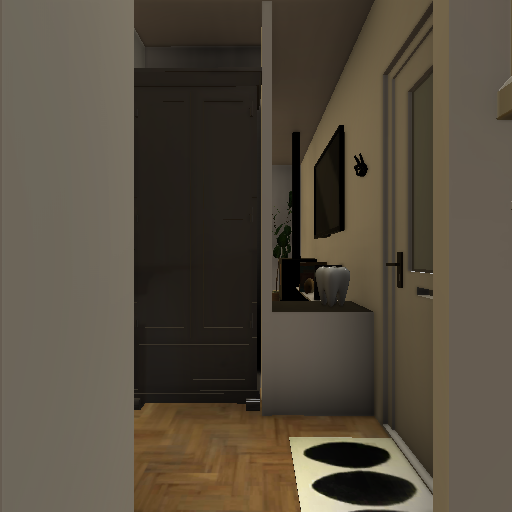

In [28]:
# obs = env.reset()
# obs = env.step({"action":("param_chl"), "action_args":{"pos_crd": path[rand][0], "angle_crd": path[rand][1]}})
for i in range(10):
    obs = env.step('move_forward')
display_sample(obs)

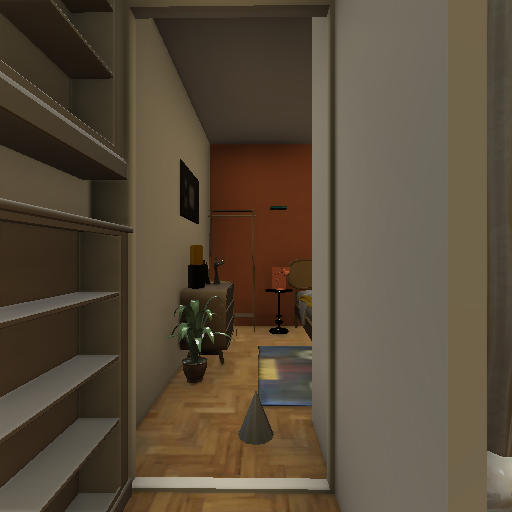

In [34]:
obs = env.step('turn_right')
display_sample(obs)

In [41]:
rigid_obj_mgr.remove_object_by_id(obj.object_id)   

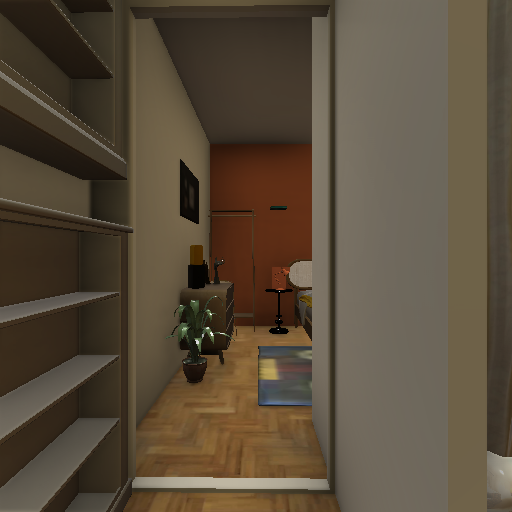

In [36]:
Image.fromarray(_sim.get_sensor_observations()['rgb'])

In [38]:
obj_template

In [42]:
id = obj_template_mgr.register_template(obj_template)
print(id)
obj = rigid_obj_mgr.add_object_by_template_id(2)
obj.translation = path[rand][0]

2


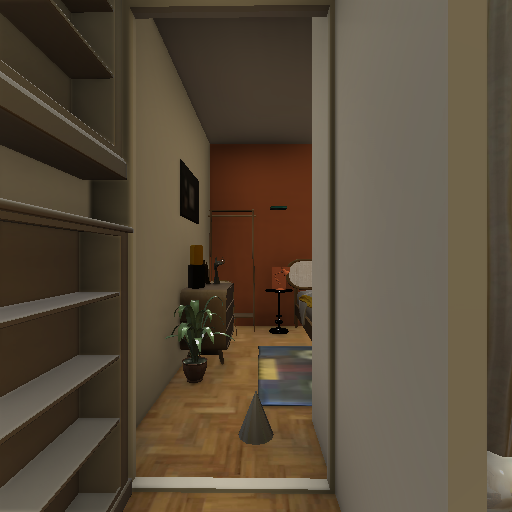

In [43]:
Image.fromarray(_sim.get_sensor_observations()['rgb'])

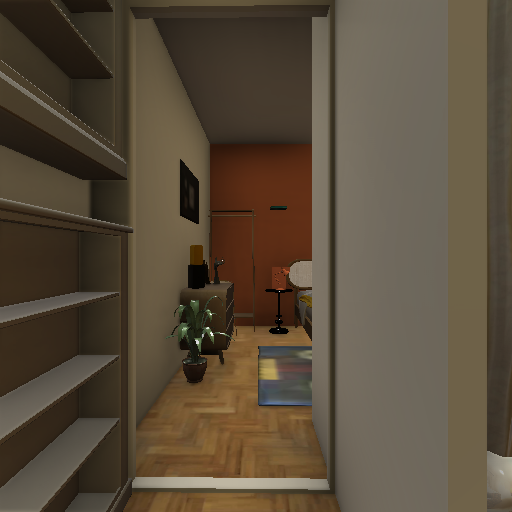

In [47]:
rigid_obj_mgr.remove_object_by_id(obj.object_id)   
Image.fromarray(_sim.get_sensor_observations()['rgb'])

16548
coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true_new_new


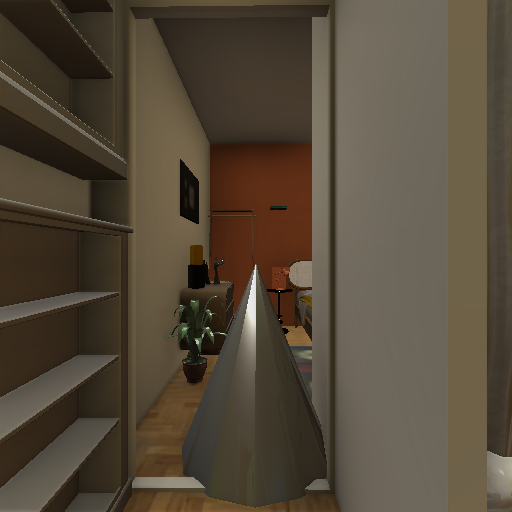

In [48]:
obj_template.scale *= 3.0
new_temp = obj_template.handle+'_new'
new_tempid = obj_template_mgr.register_template(obj_template, new_temp)
print(new_tempid)
print(obj_template_mgr.get_template_by_id(new_tempid).handle)
obj = rigid_obj_mgr.add_object_by_template_id(new_tempid)
obj.translation = path[rand][0]
Image.fromarray(_sim.get_sensor_observations()['rgb'])

In [71]:
obj.motion_type = habitat_sim.physics.MotionType.STATIC

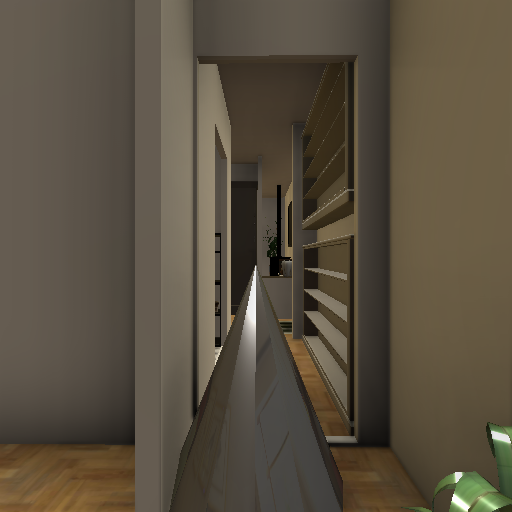

In [72]:
Image.fromarray(_sim.get_sensor_observations()['rgb'])

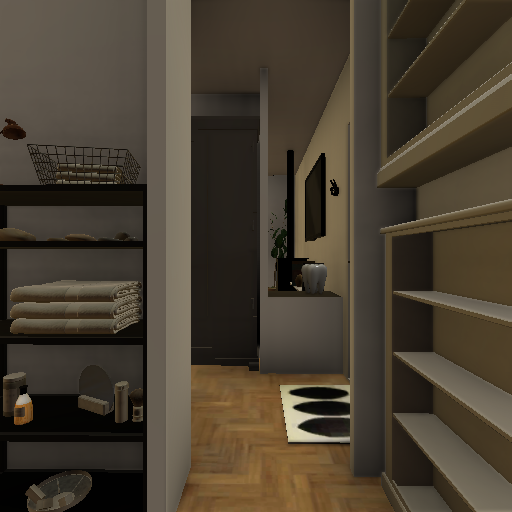

In [73]:
for i in range(10):
    obs = env.step('move_forward')
display_sample(obs)

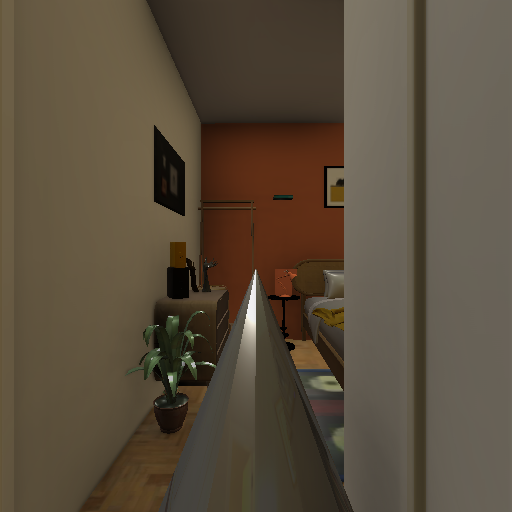

In [79]:
obs = env.step('turn_left')
display_sample(obs)

In [82]:
# recompute the NavMesh with STATIC objects
navmesh_settings = habitat_sim.NavMeshSettings()
navmesh_settings.set_defaults()
navmesh_settings.include_static_objects = True
navmesh_success = _sim.recompute_navmesh(_sim.pathfinder, navmesh_settings)


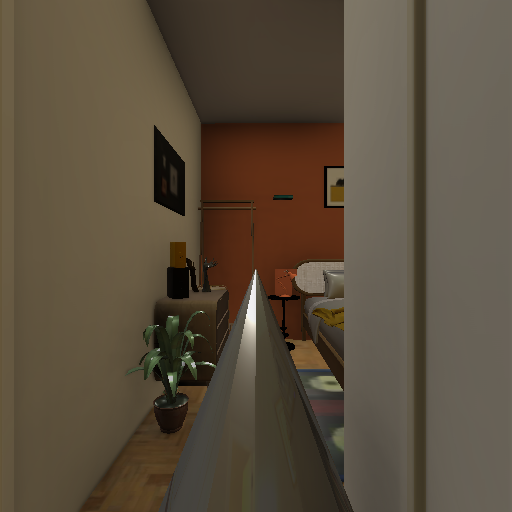

In [83]:
Image.fromarray(_sim.get_sensor_observations()['rgb'])

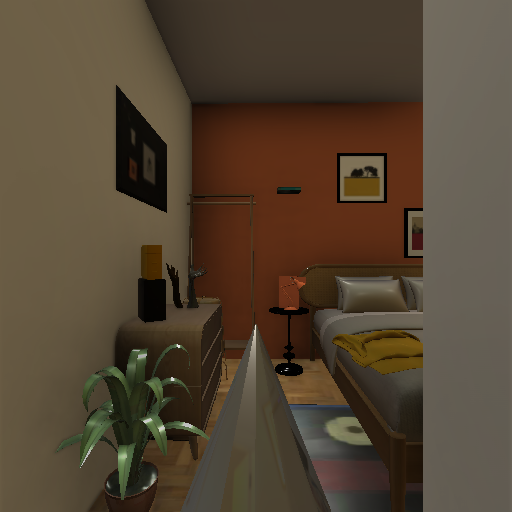

In [90]:
obs = env.step('move_forward')
display_sample(obs)

In [109]:
# Use this for object navigation task
import shutil

path = None

for episode in range(0, 10):
    env.reset()
    env.step({"action": "param_chl", "action_args": {"pos_crd": default_spawn[0], "angle_crd": default_spawn[1]}})
    IMAGE_DIR = f'{os.getcwd()}/examples/tutorials'
    dirname = os.path.join(
        IMAGE_DIR, "shortest_path_example", "%02d" % episode
    )
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.makedirs(dirname)
    print("Agent stepping around inside environment.")
    images = []
    path = []
    while not env.habitat_env.episode_over:
        best_action = follower.get_next_action(
            env.habitat_env.current_episode.goals[0].view_points[0].agent_state.position

        )
        if best_action is None:
            break
        observations, reward, done, info = env.step(best_action)
        im = observations["rgb"]
        path.append((env.habitat_env.sim.get_agent_state().position, env.habitat_env.sim.get_agent_state().rotation))
        print(info)
        # top_down_map = draw_top_down_map(info, im.shape[0])
        # output_im = np.concatenate((im, top_down_map), axis=1)
        output_im = im
        images.append(output_im)
    images_to_video(images, dirname, "trajectory")
    print("Episode finished")

Agent stepping around inside environment.
{'distance_to_goal': 4.399902820587158, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': 0.0002841949462890625}
{'distance_to_goal': 4.399902820587158, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 4.1620612144470215, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': 0.23784160614013672}
{'distance_to_goal': 4.1620612144470215, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 3.9169540405273438, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': 0.24510717391967773}
{'distance_to_goal': 3.9169540405273438, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 3.688816547393799, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': 0.22813749313354492}
{'distance_to_goal': 3.688816547393799, 'success': 0.0, 'spl': 0.0

2024-05-09 16:07:35,222 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/00/trajectory.mp4


{'distance_to_goal': 0.38812077045440674, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.2611458059306117, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.38812077045440674, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.2611458059306117, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.15888799726963043, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.27755226323923526, 'distance_to_goal_reward': 0.2292327731847763}
{'distance_to_goal': 0.10195770114660263, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.27633602271457636, 'distance_to_goal_reward': 0.0569302961230278}
{'distance_to_goal': 0.09403382241725922, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.27050725574145407, 'distance_to_goal_reward': 0.007923878729343414}
{'distance_to_goal': 0.09004271030426025, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.2645836916634024, 'distance_to_goal_reward': 0.003991112112998962}
{'distance_to_goal': 0.09004271030426025, 'success': 1.0, 'spl': 0.272965375050906, 'soft_spl': 0.2645836916634024, 'distance_t

100%|██████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 181.52it/s]
2024-05-09 16:07:35,685 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/01/trajectory.mp4


Episode finished
Agent stepping around inside environment.
{'distance_to_goal': 0.031458690762519836, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9923421100420865, 'distance_to_goal_reward': -0.0047424547374248505}
{'distance_to_goal': 0.031458690762519836, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9923421100420865, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.03865727409720421, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9905897815855075, 'distance_to_goal_reward': -0.007198583334684372}
{'distance_to_goal': 0.045275840908288956, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9889786447234874, 'distance_to_goal_reward': -0.006618566811084747}
{'distance_to_goal': 0.0486893393099308, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9881477075643851, 'distance_to_goal_reward': -0.0034134984016418457}
{'distance_to_goal': 0.0486893393099308, 'success': 1.0, 'spl': 1.0, 'soft_spl': 0.9881477075643851, 'distance_to_goal_reward': -0.0}


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 57.82it/s]

Episode finished


2024-05-09 16:07:35,964 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/02/trajectory.mp4



Agent stepping around inside environment.
{'distance_to_goal': 1.9789928197860718, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.3132398769863509, 'distance_to_goal_reward': 0.00013947486877441406}
{'distance_to_goal': 1.9789928197860718, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.3132398769863509, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.9789928197860718, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.3132398769863509, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.9789928197860718, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.3132398769863509, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.9789928197860718, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.3132398769863509, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.7353477478027344, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.3620615408734968, 'distance_to_goal_reward': 0.2436450719833374}
{'distance_to_goal': 1.4979190826416016, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.40246106895392963, 'distance_to_goal_r

100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.16it/s]


Episode finished
Agent stepping around inside environment.
{'distance_to_goal': 4.399902820587158, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': 0.0002841949462890625}
{'distance_to_goal': 4.399902820587158, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 4.1620612144470215, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': 0.23784160614013672}
{'distance_to_goal': 4.1620612144470215, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 3.9169540405273438, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': 0.24510717391967773}
{'distance_to_goal': 3.9169540405273438, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 3.688816547393799, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0, 'distance_to_goal_reward': 0.22813749313354492}
{'distance_to_goal': 3.688816547393799, 'success'

2024-05-09 16:07:36,467 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/03/trajectory.mp4


{'distance_to_goal': 0.6173012852668762, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.13944233933790773, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.38812077045440674, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.16816845785601817, 'distance_to_goal_reward': 0.22918051481246948}
{'distance_to_goal': 0.38812077045440674, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.16816845785601817, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.38812077045440674, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.16816845785601817, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.15888799726963043, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.194854431320899, 'distance_to_goal_reward': 0.2292327731847763}
{'distance_to_goal': 0.10195770114660263, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.19598550061413217, 'distance_to_goal_reward': 0.0569302961230278}
{'distance_to_goal': 0.09403382241725922, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.19051979359675617, 'distance_to_goal_reward': 0.007923878729

100%|██████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 181.47it/s]
2024-05-09 16:07:36,967 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/04/trajectory.mp4


Episode finished
Agent stepping around inside environment.
{'distance_to_goal': 0.04531467705965042, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.567205529651589, 'distance_to_goal_reward': -0.003153938800096512}
{'distance_to_goal': 0.04531467705965042, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.567205529651589, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.030866479501128197, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.511791267252358, 'distance_to_goal_reward': 0.014448197558522224}
{'distance_to_goal': 0.030866479501128197, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.511791267252358, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.03221023082733154, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.46105297440273596, 'distance_to_goal_reward': -0.0013437513262033463}
{'distance_to_goal': 0.03221023082733154, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.46105297440273596, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.033377937972545624, 'success': 0.0, 'spl': 0.0, 'soft_spl

100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.96it/s]
2024-05-09 16:07:37,231 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/05/trajectory.mp4


Episode finished
Agent stepping around inside environment.
{'distance_to_goal': 0.031458690762519836, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.7195649678318004, 'distance_to_goal_reward': -0.0047424547374248505}
{'distance_to_goal': 0.031458690762519836, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.7195649678318004, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.03865727409720421, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.6649112951546271, 'distance_to_goal_reward': -0.007198583334684372}
{'distance_to_goal': 0.045275840908288956, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.6178551465803522, 'distance_to_goal_reward': -0.006618566811084747}
{'distance_to_goal': 0.0486893393099308, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.5776131250307561, 'distance_to_goal_reward': -0.0034134984016418457}
{'distance_to_goal': 0.0486893393099308, 'success': 1.0, 'spl': 0.5900237800926132, 'soft_spl': 0.5776131250307561, 'distance_to_goal_reward': -0.0}


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 57.28it/s]
2024-05-09 16:07:37,466 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/06/trajectory.mp4


Episode finished
Agent stepping around inside environment.
{'distance_to_goal': 0.031458690762519836, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9551917821055875, 'distance_to_goal_reward': -0.0047424547374248505}
{'distance_to_goal': 0.031458690762519836, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9551917821055875, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.03865727409720421, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9148786745416787, 'distance_to_goal_reward': -0.007198583334684372}
{'distance_to_goal': 0.045275840908288956, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8778301284164574, 'distance_to_goal_reward': -0.006618566811084747}
{'distance_to_goal': 0.0486893393099308, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8440728310302655, 'distance_to_goal_reward': -0.0034134984016418457}
{'distance_to_goal': 0.0486893393099308, 'success': 1.0, 'spl': 0.8514476033705932, 'soft_spl': 0.8440728310302655, 'distance_to_goal_reward': -0.0}


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 57.32it/s]
2024-05-09 16:07:37,742 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/07/trajectory.mp4


Episode finished
Agent stepping around inside environment.
{'distance_to_goal': 1.9789928197860718, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.3404662401725428, 'distance_to_goal_reward': 0.00013947486877441406}
{'distance_to_goal': 1.9789928197860718, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.3404662401725428, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.9789928197860718, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.3404662401725428, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.9789928197860718, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.3404662401725428, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.9789928197860718, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.3404662401725428, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.7353477478027344, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.4216651959150769, 'distance_to_goal_reward': 0.2436450719833374}
{'distance_to_goal': 1.4979190826416016, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.5007924260186525, 'dis

100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.17it/s]
2024-05-09 16:07:38,043 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/08/trajectory.mp4


Episode finished
Agent stepping around inside environment.
{'distance_to_goal': 0.031458690762519836, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8551717550807076, 'distance_to_goal_reward': -0.0047424547374248505}
{'distance_to_goal': 0.031458690762519836, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8551717550807076, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.03865727409720421, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.7931297263272835, 'distance_to_goal_reward': -0.007198583334684372}
{'distance_to_goal': 0.045275840908288956, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.7393777459485583, 'distance_to_goal_reward': -0.006618566811084747}
{'distance_to_goal': 0.0486893393099308, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.6930312987919126, 'distance_to_goal_reward': -0.0034134984016418457}
{'distance_to_goal': 0.0486893393099308, 'success': 1.0, 'spl': 0.7050179460398966, 'soft_spl': 0.6930312987919126, 'distance_to_goal_reward': -0.0}


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 54.77it/s]
2024-05-09 16:07:38,367 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/09/trajectory.mp4


Episode finished
Agent stepping around inside environment.
{'distance_to_goal': 0.026208605617284775, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9967753576139053, 'distance_to_goal_reward': -0.005935493856668472}
{'distance_to_goal': 0.026208605617284775, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9967753576139053, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.026208605617284775, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9967753576139053, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.026208605617284775, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9967753576139053, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.026208605617284775, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9967753576139053, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.04984712600708008, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9938669321941559, 'distance_to_goal_reward': -0.023638520389795303}
{'distance_to_goal': 0.11462448537349701, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.98589688

100%|██████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 146.63it/s]


Episode finished


In [110]:
dirname

'/data/reventh/habitat-lab/examples/tutorials/shortest_path_example/09'

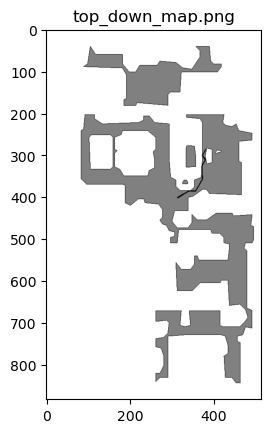

In [111]:
from habitat.utils.visualizations import maps

top_down_map = maps.get_topdown_map_from_sim(env.habitat_env.sim, map_resolution=512)
recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        # By default, `get_topdown_map_from_sim` returns image
        # containing 0 if occupied, 1 if unoccupied, and 2 if border
        # The line below recolors returned image so that
        # occupied regions are colored in [255, 255, 255],
        # unoccupied in [128, 128, 128] and border is [0, 0, 0]
top_down_map = recolor_map[top_down_map]
reformatted_path = [maps.to_grid(x[0][2], x[0][0], (top_down_map.shape[0], top_down_map.shape[1]), env.habitat_env.sim) for x in path]
maps.draw_path(top_down_map, reformatted_path, color=10, thickness=2)
plt.imshow(top_down_map)
plt.title("top_down_map.png")
plt.show()